# MLP
This is the first of many notebooks that investigate insights and differences between deep learning architectures from MLPs and CNNs. This focuses on the FashionMNIST dataset, an image dataset of various clothing items labeled by what they are. The images are relative simple, being 28x28 pixels, allowing for a image-based multiclass classification task.

This first notebook is an introduction to the dataset and deeper insights about initialization, architecture depth/width, and dropout that will not be as rigorously tested in the future notebooks.

In [31]:
import torch
from torch import nn
from d2l import torch as d2l

In [32]:
import torch
import numpy as np
import random
import os

def set_pytorch_seed(seed: int = 42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

## Data Visualization
The FashionMNIST dataset is loaded using many of D2L's functions, showing the power of object-oriented software design.

In [33]:
data = d2l.FashionMNIST(batch_size=128)

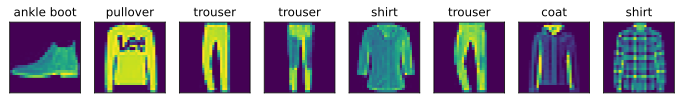

In [34]:
data.visualize(next(iter(data.val_dataloader())))

Each data sample is a 28 by 28 pixel image. There is only a single channel.

In [35]:
data.train[0][0].shape

torch.Size([1, 28, 28])

## Multilayer Perceptron
We start the baseline classification task with a multilayer perceptron. To start, we do a standard MLP on the dataset. In order to processes 2D image data, we must flatten out the images into a single dimension. The cross entropy loss is an appropriate loss function for classification.

In [36]:
class MLP(d2l.Module):
    def __init__(self, lr=0.1, num_classes=10, hidden_layers=(256,)):
        super().__init__()
        self.save_hyperparameters()
        self.hidden = nn.Sequential(
            *(nn.Sequential(nn.LazyLinear(h), nn.ReLU()) for h in hidden_layers)
        )
        self.out = nn.LazyLinear(num_classes)
    
    def forward(self, x):
        x = x.flatten(start_dim=1)
        hidden_out = self.hidden(x)
        return self.out(hidden_out)

    def loss(self, y_hat, y):
        return nn.functional.cross_entropy(y_hat, y)

In [37]:
def evaluate_model(model, data_loader):
    metric = d2l.Accumulator(2)
    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            y_hat = model(X)
            metric.add(d2l.accuracy(y_hat, y), y.numel())
    return metric[0] / metric[1]

As we can see below, the MLP has uninitialized parameters. For now, let's see what happens when we train this MLP.

In [38]:
mlp = MLP(hidden_layers=(128,64))
mlp.state_dict()

/home/jiwonjjeong/miniforge3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


OrderedDict([('hidden.0.0.weight', <UninitializedParameter>),
             ('hidden.0.0.bias', <UninitializedParameter>),
             ('hidden.1.0.weight', <UninitializedParameter>),
             ('hidden.1.0.bias', <UninitializedParameter>),
             ('out.weight', <UninitializedParameter>),
             ('out.bias', <UninitializedParameter>)])

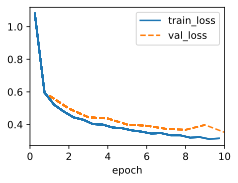

In [39]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(mlp, data)

In [40]:
acc = evaluate_model(mlp, data.val_dataloader())
print("Final val accuracy:", acc)

Final val accuracy: 0.8719


A final validation accuracy is fairly high at 87.19%. Let's keep this as our benchmark as the most standard, vanilla MLP.

### Initialization
As observed, we did not initialize the model parameters, so the model trained with default weight starts. We should take care to initialize our parameters at the start. Controlling the initialization can improve the training speed and avoid numerical instability from exploding/vanishing gradients. In this section, we will compare the training of the same MLP under different initializations. We first start with the Xavier Initialization.

In [41]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [42]:
mlpx = MLP(hidden_layers=(128,64))
mlpx.forward(next(iter(data.val_dataloader()))[0]) # next(iter(...)) gets the (X,y) tuple of next batch
mlpx.apply(init_weights)
mlpx.state_dict()['hidden.0.0.weight']

tensor([[-0.0344, -0.0611,  0.0103,  ...,  0.0706, -0.0654, -0.0236],
        [-0.0227, -0.0044,  0.0802,  ...,  0.0584,  0.0178, -0.0316],
        [-0.0412, -0.0582, -0.0148,  ..., -0.0558, -0.0695,  0.0189],
        ...,
        [ 0.0771, -0.0308,  0.0800,  ..., -0.0253, -0.0684,  0.0177],
        [ 0.0659,  0.0416,  0.0729,  ...,  0.0156, -0.0056,  0.0352],
        [ 0.0104,  0.0282,  0.0716,  ..., -0.0094, -0.0590, -0.0722]])

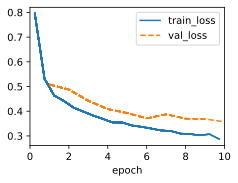

In [43]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(mlpx, data)

In [44]:
accx = evaluate_model(mlpx, data.val_dataloader())
print("Final val accuracy:", accx)

Final val accuracy: 0.8666


Recall that our uninitialized baseline accuracy if 87.19% for the default initialization. It seems that the Xavier initialization performs similar. Let's compare to another common initialization scheme. This is the Kaiming Initialization. Specifically, we indicate that the ReLU activation will be used.

In [45]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [46]:
mlpk = MLP(hidden_layers=(128,64))
mlpk.forward(next(iter(data.val_dataloader()))[0]) # next(iter(...)) gets the (X,y) tuple of next batch
mlpk.apply(init_weights)
mlpk.state_dict()['hidden.0.0.weight']

tensor([[ 0.0211, -0.0617,  0.0664,  ..., -0.0054,  0.0599,  0.0211],
        [-0.0399,  0.0468, -0.0052,  ...,  0.0786, -0.0440,  0.0528],
        [ 0.0272, -0.0551, -0.0776,  ...,  0.0322,  0.0511,  0.0038],
        ...,
        [-0.0009, -0.0396,  0.0013,  ..., -0.0011, -0.0327, -0.0545],
        [-0.0757,  0.0393, -0.0449,  ..., -0.0568,  0.0700, -0.0707],
        [ 0.0541, -0.0145, -0.0811,  ..., -0.0610, -0.0625,  0.0393]])

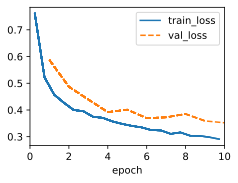

In [47]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(mlpk, data)

In [48]:
acck = evaluate_model(mlpk, data.val_dataloader())
print("Final val accuracy:", acck)

Final val accuracy: 0.8721


Again, the Kaiming initialization for ReLU performs similar to the default initialization. This is expected, because the default initialization scheme for Linear layers in PyTorch uses the Kaiming initialization.

As an additional comparison, let's also see what happens when we perform more naive initializations. For example, let's initialize all the parameter values to the same number, 0.

In [49]:
def init_weights_zeros(m):
    if isinstance(m, nn.Linear):
        nn.init.zeros_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

mlpz = MLP(hidden_layers=(128,64))
mlpz.forward(next(iter(data.val_dataloader()))[0]) # next(iter(...)) gets the (X,y) tuple of next batch
mlpz.apply(init_weights_zeros)
mlpz.state_dict()['hidden.0.0.weight']

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

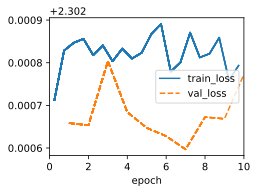

In [50]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(mlpz, data)

In [51]:
accz = evaluate_model(mlpz, data.val_dataloader())
print("Final val accuracy:", accz)

Final val accuracy: 0.1


Yikes! This is definitely worse than the other common initializations. Even convergence is difficult with this poor initialization. What if we choose something in between this naive and the Kaiming or Xaivier initializations? Initializing the weights across a uniform distribution sounds like a possible strategy.

In [52]:
def init_weights_uniform(m):
    if isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight, a=0.0, b=1.0)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

mlpu = MLP(hidden_layers=(128,64))
mlpu.forward(next(iter(data.val_dataloader()))[0]) # next(iter(...)) gets the (X,y) tuple of next batch
mlpu.apply(init_weights_uniform)
mlpu.state_dict()['hidden.0.0.weight']

tensor([[0.9610, 0.2449, 0.2861,  ..., 0.1167, 0.4328, 0.4885],
        [0.7553, 0.6319, 0.1510,  ..., 0.4932, 0.8731, 0.5010],
        [0.3572, 0.2699, 0.1377,  ..., 0.0754, 0.5839, 0.2510],
        ...,
        [0.4827, 0.5255, 0.5774,  ..., 0.0528, 0.7215, 0.9569],
        [0.3393, 0.6629, 0.2753,  ..., 0.9458, 0.8352, 0.7254],
        [0.8376, 0.1481, 0.1779,  ..., 0.4968, 0.3740, 0.3350]])

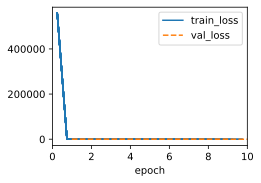

In [53]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(mlpu, data)

In [54]:
accu = evaluate_model(mlpu, data.val_dataloader())
print("Final val accuracy:", accu)

Final val accuracy: 0.1


Still yikes! It seems like the uniform initialization also leads to poor (or at least slow) convergence. These last two examples (zero initialization and uniform initialization) more clearly show that a good initialization strategy is important to achieving (efficient) convergence.

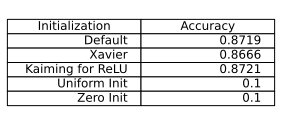

In [55]:
# Summarize findings
import matplotlib.pyplot as plt

col1 = ["Default", "Xavier", "Kaiming for ReLU", "Uniform Init", "Zero Init"]
col2 = [acc, accx,acck, accu, accz]

# Create figure
fig, ax = plt.subplots(figsize=(4, 2))
ax.axis("off")  # Hide axes

# Combine into rows
table_data = list(zip(col1, col2))

# Create table
table = ax.table(
    cellText=table_data,
    colLabels=["Initialization", "Accuracy"],
    loc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

plt.show()

Though these are not rigorous tests to prove any reliable results about different initializations. It is clear that the initialization does affect the speed at which parameters converge. In more complex algorithms, the initialization may also be necessary to prevent numerical instability. For the rest of this investigation, the standard Xavier initialization will be used. It is also the empirically best result in our very crude experiment.

In [56]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

## Sufficiency of Architecture
Although we consider MLPs as universal function approximaters, not all MLP architectures can represent every function. An extreme example is if the very MLP hidden layer has a size (width) of one. We would condense all the rich, input signals into a single linear boundary and lose a lot of the granularity in the data.

Without knowing the required sufficiency of architecture, it is often easier to overparameterize. Overparameterized architectures often tend to train better as well. Let's visualize some of these claims through changing the depth and width of the MLPs.

In [57]:
class MLP(d2l.Module):
    def __init__(self, lr=0.1, num_classes=10, hidden_layers=(256,)):
        super().__init__()
        self.save_hyperparameters()
        self.hidden = nn.Sequential(
            *(nn.Sequential(nn.LazyLinear(h), nn.ReLU()) for h in hidden_layers)
        )
        self.out = nn.LazyLinear(num_classes)
    
    def forward(self, x):
        x = x.flatten(start_dim=1)
        hidden_out = self.hidden(x)
        return self.out(hidden_out)

    def loss(self, y_hat, y):
        return nn.functional.cross_entropy(y_hat, y)

In [58]:
mlp = MLP(hidden_layers=(128,64))
mlp.forward(next(iter(data.val_dataloader()))[0]) # next(iter(...)) gets the (X,y) tuple of next batch
mlp.apply(init_weights)

MLP(
  (hidden): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
    )
  )
  (out): Linear(in_features=64, out_features=10, bias=True)
)

KeyboardInterrupt: 

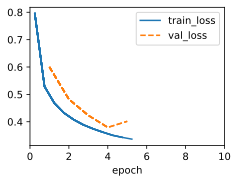

In [59]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(mlp, data)

In [ ]:
acc = evaluate_model(mlp, data.val_dataloader())
print("Final val accuracy:", acc)

Final val accuracy: 0.8698


Now let's see how the model performs when we do an extreme architecture with a very small initial hidden layer size.

In [ ]:
mlp_inverted = MLP(hidden_layers=(8,64))
mlp_inverted.forward(next(iter(data.val_dataloader()))[0]) # next(iter(...)) gets the (X,y) tuple of next batch
mlp_inverted.apply(init_weights)

/home/jiwonjjeong/miniforge3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


MLP(
  (hidden): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=8, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=8, out_features=64, bias=True)
      (1): ReLU()
    )
  )
  (out): Linear(in_features=64, out_features=10, bias=True)
)

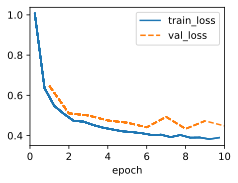

In [ ]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(mlp_inverted, data)

In [ ]:
acc = evaluate_model(mlp_inverted, data.val_dataloader())
print("Final val accuracy:", acc)

Final val accuracy: 0.8337


Oddly, it seems that the results are not too different! But what if we go even more extreme?

In [ ]:
mlp_inverted_ex = MLP(hidden_layers=(2,64))
mlp_inverted_ex.forward(next(iter(data.val_dataloader()))[0]) # next(iter(...)) gets the (X,y) tuple of next batch
mlp_inverted_ex.apply(init_weights)

/home/jiwonjjeong/miniforge3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


MLP(
  (hidden): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=2, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): ReLU()
    )
  )
  (out): Linear(in_features=64, out_features=10, bias=True)
)

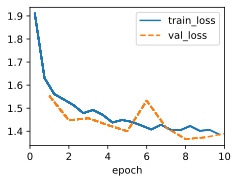

In [ ]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(mlp_inverted_ex, data)

In [ ]:
acc = evaluate_model(mlp_inverted_ex, data.val_dataloader())
print("Final val accuracy:", acc)

Final val accuracy: 0.3843


Yikes! Now we see some more poor performance with an insufficient architecture. Let's visualize how the accuracy of the model changes with changing the first hidden layer size. We hold the hidden layer size of the second hidden layer the same throughout this section at 64.

Hidden layer size: 2, Final val accuracy: 0.5924


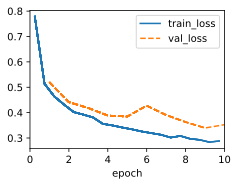

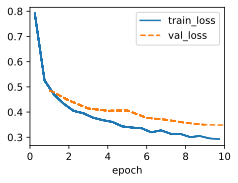

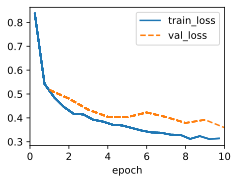

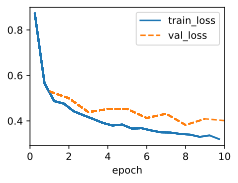

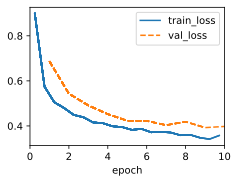

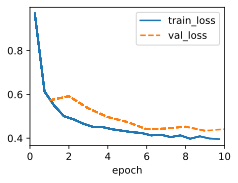

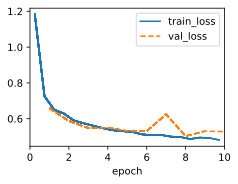

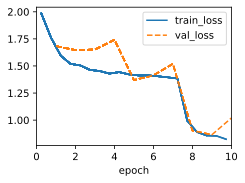

In [ ]:
first_hidden_layer_sizes = [256, 128, 64, 32, 16, 8, 4, 2]
accuracies = []

for size in first_hidden_layer_sizes:
    mlp_model = MLP(hidden_layers=(size, 64))
    mlp_model.forward(next(iter(data.val_dataloader()))[0]) # next(iter(...)) gets the (X,y) tuple of next batch
    mlp_model.apply(init_weights)
    trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
    trainer.fit(mlp_model, data)
    acc = evaluate_model(mlp_model, data.val_dataloader())
    accuracies.append(acc)
    print(f"Hidden layer size: {size}, Final val accuracy: {acc}")

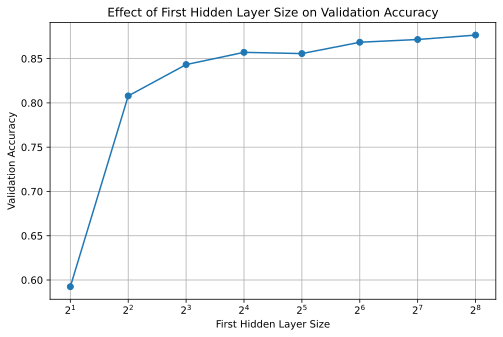

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(first_hidden_layer_sizes, accuracies, marker='o')
plt.xscale('log', base=2)
plt.xlabel('First Hidden Layer Size')
plt.ylabel('Validation Accuracy')
plt.title('Effect of First Hidden Layer Size on Validation Accuracy')
plt.grid(True)
plt.show()

It seems that for this classification task, the minimum sufficient archiecture is quickly met with an initial hidden layer size of 8+. Still, this project will overparameterize. The point of this investigation is to show that such relationship between the granularity of the first layer and the representative power of the entire architecture exists (especially at extremeley small first hidden layer sizes).

The next question is, how does depth matter? Typically MLP depth contributes to higher complexity boolean and function representations with the same number of neurons. My expectation is that removal of the second 64-width hidden layer to create a 1-layer MLP will result in decreased performance if we compare architecutres that contain the same number of neuronos. To experiment, I will compare 1-layer and 2-layer MLPs with the same number of neurons. The 1-layer MLP will have a single, wide linear layer while the 2-layer MLP with have two, half-wide linear layers.

Total hidden neurons (2-layers): 2, Final val accuracy: 0.4087


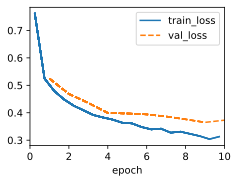

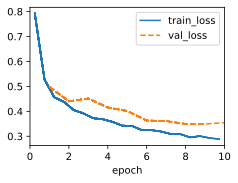

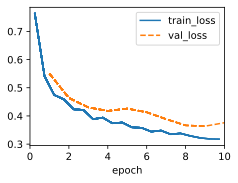

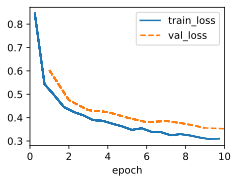

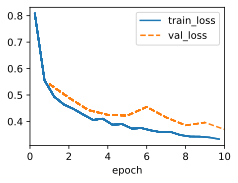

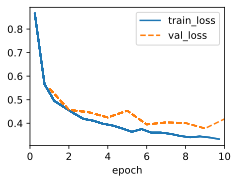

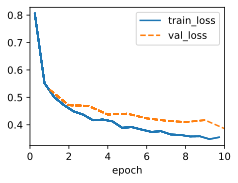

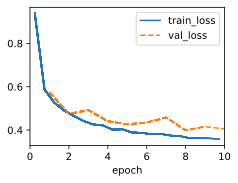

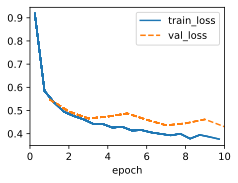

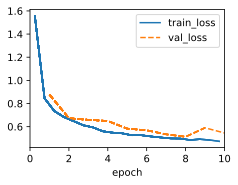

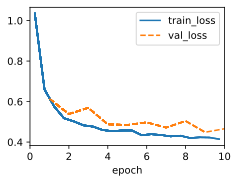

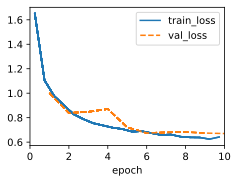

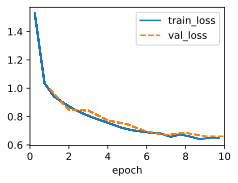

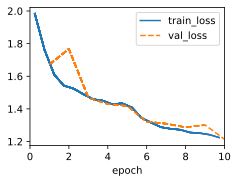

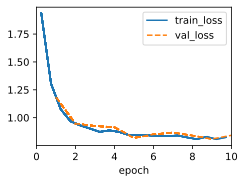

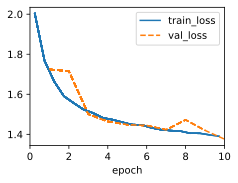

In [ ]:
num_neurons = [256, 128, 64, 32, 16, 8, 4, 2]
accuracies_1layer = []
accuracies_2layer = []

for size in first_hidden_layer_sizes:
    mlp_model = MLP(hidden_layers=(size,))
    mlp_model.forward(next(iter(data.val_dataloader()))[0]) # next(iter(...)) gets the (X,y) tuple of next batch
    mlp_model.apply(init_weights)
    trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
    trainer.fit(mlp_model, data)
    acc = evaluate_model(mlp_model, data.val_dataloader())
    accuracies_1layer.append(acc)
    print(f"Total hidden neurons (1-layer): {size}, Final val accuracy: {acc}")
    mlp_model2 = MLP(hidden_layers=(int(size/2),int(size/2)))
    mlp_model2.forward(next(iter(data.val_dataloader()))[0]) # next(iter(...)) gets the (X,y) tuple of next batch
    mlp_model2.apply(init_weights)
    trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
    trainer.fit(mlp_model2, data)
    acc = evaluate_model(mlp_model2, data.val_dataloader())
    accuracies_2layer.append(acc)
    print(f"Total hidden neurons (2-layers): {size}, Final val accuracy: {acc}")

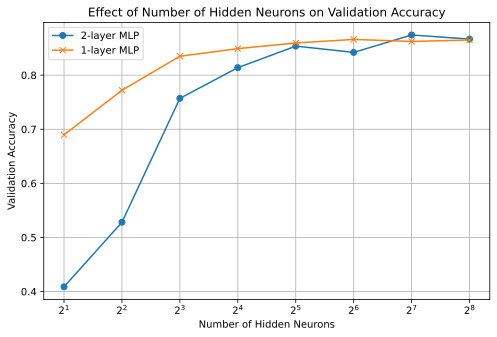

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(first_hidden_layer_sizes, accuracies_2layer, marker='o')
plt.plot(first_hidden_layer_sizes, accuracies_1layer, marker='x')
plt.xscale('log', base=2)
plt.xlabel('Number of Hidden Neurons')
plt.ylabel('Validation Accuracy')
plt.title('Effect of Number of Hidden Neurons on Validation Accuracy')
plt.legend(['2-layer MLP', '1-layer MLP'])
plt.grid(True)
plt.show()


Interestingly, it seems that the deeper architecture did not perform as well with the same number of neurons as the 1-hidden layer MLP. This is an unexpected finding. At least for the very low number of hidden neurons, one possible explanation is that the hidden layer size of the 1-layer MLP is twice the size of the 2-layer MLP. Maybe the 2-layer MLP first hidden layer size is too small to capture the granularity of the data.

### Dropout and Generalization

In [ ]:
class LeNet(d2l.Classifier):
    """This is the base lenet model (with some adjustment of activation function for computational ease)."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

In [ ]:
def init_cnn(module):
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

In [ ]:
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
[(name, param.shape) for name, param in model.named_parameters()]

[('net.0.weight', torch.Size([6, 1, 5, 5])),
 ('net.0.bias', torch.Size([6])),
 ('net.3.weight', torch.Size([16, 6, 5, 5])),
 ('net.3.bias', torch.Size([16])),
 ('net.7.weight', torch.Size([120, 400])),
 ('net.7.bias', torch.Size([120])),
 ('net.9.weight', torch.Size([84, 120])),
 ('net.9.bias', torch.Size([84])),
 ('net.11.weight', torch.Size([10, 84])),
 ('net.11.bias', torch.Size([10]))]

In [ ]:
model.state_dict()

OrderedDict([('net.0.weight',
              tensor([[[[-0.1041,  0.1210, -0.0691, -0.1167,  0.0502],
                        [ 0.0308,  0.0811,  0.1288,  0.0153, -0.0353],
                        [ 0.0490, -0.0151, -0.1457, -0.1054,  0.1315],
                        [ 0.0630,  0.1292,  0.1013, -0.1645, -0.0930],
                        [ 0.0057,  0.0744, -0.1120,  0.1686, -0.1240]]],
              
              
                      [[[ 0.0616, -0.0979, -0.1544, -0.0687,  0.1489],
                        [-0.1766,  0.0582, -0.1279, -0.0794,  0.1487],
                        [ 0.1561, -0.1149, -0.0371,  0.1021,  0.1576],
                        [-0.1435, -0.1072, -0.1031, -0.1304, -0.0357],
                        [-0.0382,  0.0304, -0.0301,  0.0436,  0.1695]]],
              
              
                      [[[ 0.1461, -0.1273, -0.1323, -0.0353, -0.0440],
                        [-0.1294, -0.1054,  0.1776, -0.0842,  0.0417],
                        [ 0.0038,  0.1097,  0.0124,  0

In [ ]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, data)